In [49]:
import matplotlib.pyplot as plt
import math
from scipy.linalg import hadamard
from sklearn import linear_model
import numpy as np
from numpy import *
from numpy import linalg as LA
import pandas as pd
import types
import random
from math import *
from scipy.optimize import minimize

# RLA functions

In [2]:
def RLA_mult(A, B, c, distribution = "uniform"):
    """
    This function takes two large matrices A and B,
    and computes A*B through random linear algebra method.

    input:
    A: m * n matrix (it can be numpy array or 2D python list)
    B: n * p matrix (it can be numpy array or 2D python list)
    c: positive integer, the number of samples
    distribution: takes two values ["uniform", "minvar"]
                  "minvar" is a probability distribution minimizes variance.
    ----------------
    output: approximation for AB
    """

    # convert A and B to numpy arrays
    if type(A) is list:
        A = np.array(A)
    if type(B) is list:
        B = np.array(B)


    m = A.shape[0]    # A: m*n; B:n*p
    n = A.shape[1]
    p = B.shape[1]
    # check if dimensions of two matrices match
    if n != B.shape[0]:
        print("Dimensions of two matrices don't match.")
        return


    # if the selected sampling distribution is uniform
    if distribution == "uniform":
        answer = np.zeros((m, p))
        for t in range(c):
            i = random.randint(0, n-1)
            A_icol = A[:, [i]]
            B_irow = B[[i], :]
            answer += np.matmul(A_icol, B_irow)
        return n * answer / c


    # if the selected sampling distribution is to minimize variance
    elif distribution == "minvar":
        # calculate the sample distribution
        weight_sum = 0
        weights = []
        for i in range(n):
            w = np.linalg.norm(A[:, i]) * np.linalg.norm(B[i, :])
            weights.append(w)
            weight_sum += w
        weights = np.array(weights) / weight_sum

        # sample and calculate the answer
        answer = np.zeros((m, p))
        for t in range(c):
            i = np.random.choice(np.arange(0, n), p = weights)
            A_icol = A[:, [i]]
            B_irow = B[[i], :]
            answer += np.matmul(A_icol, B_irow) * (1/weights[i])
        return answer / c

    else:
        print("Probability distribution type not valid.")





def generate_matrix(m, n, method=1, param = [0,1]):
    """
    This function takes in dimensions m and n,
    to randomly generate a matrix of m*n.
    Each element in the matrix is drawn according to the method and param specified.

    input:
    m: int; the number of rows
    n: int; the number of columns
    method: int; represent the method/distirbution we generate matrix from
            method = 1: all elements drawn from Uniform(param[0], param[1]).
            method = 2: all elements drawn from Normal(param[0], param[1]^2)
            method = 3: all elements are binary, take either 0 (probability of param[0]) or 1 (probability of param[1]),
                        where param[0]+param[1] = 1.
    ----------------
    output: a 2-D numpy array representing the randomly generated matrix according to method and param.
    """
    # uniform distribution
    if method == 1:
        M = np.random.rand(m,n)
        if len(param) != 2:
            return M
        M = M * (param[1]-param[0])
        M = M + param[0]
        return M

    # normal distribution
    if method == 2:
        if len(param) != 2:
            return np.random.normal(0, 1, size=(m, n))
        else:
            return np.random.normal(param[0], param[1], size=(m, n))

    # bernoumlli distribution
    if method == 3:
        M = np.zeros((m,n))
        for i in range(m):
            for j in range(n):
                elem = np.random.choice(np.arange(0, 2), p = param)
                M[i,j] = elem
        return M

    else:
        print("Specified method not recognized.")






def frobenius_dist(true_mat, approx_mat):
    """
    This function computes the frobenius distance between the approximated matrix
    and the true matrix.
    Which is given by the frobenius norm of (true_mat-approx_mat)/

    input:
    true_mat: numpy 2-D array; the true matrix
    approx_mat: numpy 2-D array; the approximated matrix
    ----------------
    output: double; the frobenius distance between true_mat and approx_mat
    """
    if true_mat.shape[0] == approx_mat.shape[0] and true_mat.shape[1] == approx_mat.shape[1]:
        diff = true_mat - approx_mat
        return LA.norm(diff, 'fro')
    else:
        print("Dimensions of two matricies doesn't match.")

In [3]:
def traditional_mult(A, B):
    """
    This function takes two large matrices A and B,
    and computes A*B through traditional multiplication method. 

    input:
    A: m * n matrix (it can be numpy array or 2D python list)
    B: n * p matrix (it can be numpy array or 2D python list)
    ----------------
    output: AB
    """

    # convert A and B to numpy arrays
    if type(A) is list:
        A = np.array(A)
    if type(B) is list:
        B = np.array(B)
        
    m = A.shape[0]    # A: m*n; B:n*p
    n = A.shape[1]
    p = B.shape[1]
    # check if dimensions of two matrices match
    if n != B.shape[0]:
        print("Dimensions of two matrices don't match.")
        return
    
    AB = np.zeros((m,p))
    
    for i in range(m):
        for j in range(p):
            AB[i,j] = np.matmul(A[i,:],B[:,j])
    
    return AB

# Randomized Lasso Regression 1: randon sampling

In [4]:
def RLasso_sampling(A, b, err_tolerance, alpha=0.1):
    """
    A is a n*d matrix, b is a n-element vector.
    We aim to use random sampling to construct a reduced version of the problem,
    and solve through LASSO regression.
    
    input: 
    A: numpy 2D array of n*d representing data points where n is the number of data points
    b: n-element vector
    alpha: hyperparameter representing the coefficient in front of LASSO regularizing factor
    err_tolerance: error tolerance for the randomized regression
    ---------------------------------
    output: a model object that contains approximated solution x for Ax=b using LASSO regression
    """
    n = A.shape[0]
    d = A.shape[1]

    # compute the proper r
    ln40nd = np.log(40*n*d)
    r = max(48*48*d*ln40nd*np.log(10000*d*ln40nd), 40*d*ln40nd/err_tolerance)
    r = int(r)
    
    # construct S matrix
    S = np.zeros((n,r))
    for l in range(r):
        k_l = random.randint(0, n-1)
        S[k_l, l] = math.sqrt(n/r)

    
    # construct H, note that H is n*n where n is a power of 2
    # find the smallest power of 2 n' greater or equal to n 
    power =  ceil(np.log2(n))
    n_ = pow(2, power) 
    H = hadamard(n_)/sqrt(n_)
    # truncate H to only have n*n entries
    H = H[0:n,0:n]
    
    # construct D, note that D is n*n diagonal matrix
    D = np.identity(n)
    for i in range(n):
        if random.random() < 0.5:
            D[i,i] = -1
    
    P = np.matmul(np.matmul(np.transpose(S), H), D)
    newA = np.matmul(P, A)
    newb = np.matmul(P, b)
    
    # solve the lasso regression problem
    clf = linear_model.Lasso(alpha=alpha)
    clf.fit(newA, newb)
    
    # returns a model object.
    # use clf.intercept_ to get the intercept
    # use clf.coef_ to get the coefficients
    return clf

Tests on accuracy and performance by fitting our randomized Lasso regression on generated simluation data. 

In [32]:
"""Generate random data"""
size = 256
alpha = 0.001

np.random.seed(1)
X = 2.5 * np.random.randn(size) + 1.5
res = 1 * np.random.randn(size)
y = 2 + 0.6 * X + res

X = X.reshape((size,1))
y = y.reshape((size,1))

In [33]:
"""Fitting data and predicting data using randomized LASSO regression"""
RLasso_model = RLasso_sampling(X, y, 1, alpha=alpha)
print(RLasso_model.coef_)
print(RLasso_model.intercept_)

# calculate the prediction
RLasso_ypred = X*RLasso_model.coef_[0] + RLasso_model.intercept_[0]

[0.88886093]
[-0.00482703]


In [34]:
"""Fitting data and predicting data using randomized traditional regression"""
TLasso_model = linear_model.Lasso(alpha=alpha)
TLasso_model.fit(X, y)
print(TLasso_model.coef_)
print(TLasso_model.intercept_)

# calculate the prediction
TLasso_ypred = X*TLasso_model.coef_[0] + TLasso_model.intercept_[0]

[0.61856297]
[2.00148296]


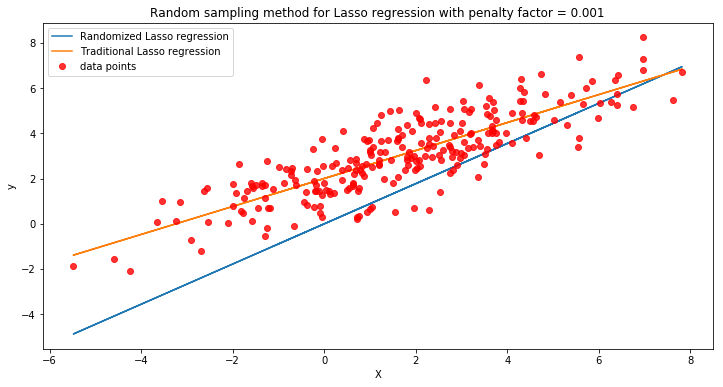

In [35]:
# Plot regression against actual data
plt.figure(figsize=(12, 6))
plt.plot(X, RLasso_ypred, label="Randomized Lasso regression")     # randomized Lasso regression line
plt.plot(X, TLasso_ypred, label="Traditional Lasso regression")     # traditional Lasso regression line
plt.plot(X, y, 'ro', label="data points", alpha = 0.8)   # scatter plot showing actual data
plt.title("Random sampling method for Lasso regression with penalty factor = 0.001")
plt.xlabel('X')
plt.ylabel('y')

plt.legend()

# Randomized Lasso Regression 2: randon projection

In [36]:
def RLasso_projection(A, b, err_tolerance, Cq, Ck, alpha=0.1):
    """
    A is a n*d matrix, b is a n-element vector.
    We aim to use random sampling to construct a reduced version of the problem,
    and solve through LASSO regression.
    
    input: 
    A: numpy 2D array of n*d representing data points where n is the number of data points
    b: n-element vector
    alpha: hyperparameter representing the coefficient in front of LASSO regularizing factor
    err_tolerance: error tolerance for the randomized regression
    Cq: tunable hyperparameters according to the random projection algorithm
    Ck: tunable hyperparameters according to the random projection algorithm
    ---------------------------------
    output: a model object that contains approximated solution x for Ax=b using LASSO regression
    """
    n = A.shape[0]
    d = A.shape[1]

    # compute the proper r
    ln40nd = np.log(40*n*d)
    q = Cq*d*ln40nd/n*(2*np.log(n)+16*d+16)
    print(q)
    r = int(max(Ck*(188*188*d+98*98), 60*d/err_tolerance))
    
    # construct T matrix
    T = np.zeros((r,n))
    for i in range(r):
        for j in range(n):
            possible_entries = [sqrt(1/r/q), -sqrt(1/r/q), 0]
            weights = [q/2, q/2, 1-q]
            T[i,j] = np.random.choice(possible_entries, p = weights)
    
    # construct H, note that H is n*n where n is a power of 2
    # find the smallest power of 2 n' greater or equal to n 
    power =  ceil(np.log2(n))
    n_ = pow(2, power) 
    H = hadamard(n_)/sqrt(n_)
    # truncate H to only have n*n entries
    H = H[0:n,0:n]
    
    # construct D, note that D is n*n diagonal matrix
    D = np.identity(n)
    for i in range(n):
        if random.random() < 0.5:
            D[i,i] = -1
    
    P = np.matmul(np.matmul(T, H), D)
    newA = np.matmul(P, A)
    newb = np.matmul(P, b)
    
    # solve the lasso regression problem
    clf = linear_model.Lasso(alpha=alpha)
    clf.fit(newA, newb)
    
    # returns a model object.
    # use clf.intercept_ to get the intercept
    # use clf.coef_ to get the coefficients
    return clf

In [43]:
"""Generate random data"""
size = 256
alpha = 0.001

np.random.seed(1)
X = 2.5 * np.random.randn(size) + 1.5
res = 1 * np.random.randn(size)
y = 2 + 0.6 * X + res

X = X.reshape((size,1))
y = y.reshape((size,1))

In [44]:
"""Fitting data and predicting data using randomized LASSO regression"""
RpLasso_model = RLasso_projection(X, y, 1, 0.001, 0.001, alpha=alpha)
print(RpLasso_model.coef_)
print(RpLasso_model.intercept_)

# calculate the prediction
RpLasso_ypred = X*RpLasso_model.coef_[0] + RpLasso_model.intercept_[0]

0.0015542921438485746
[1.05589898]
[-0.52284563]


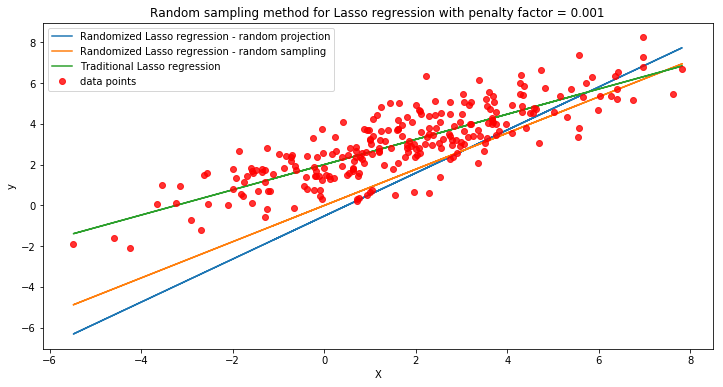

In [45]:
# Plot regression against actual data
plt.figure(figsize=(12, 6))
plt.plot(X, RpLasso_ypred, label="Randomized Lasso regression - random projection")     # randomized Lasso regression line
plt.plot(X, RLasso_ypred, label="Randomized Lasso regression - random sampling")     # randomized Lasso regression line
plt.plot(X, TLasso_ypred, label="Traditional Lasso regression")     # traditional Lasso regression line
plt.plot(X, y, 'ro', label="data points", alpha = 0.8)   # scatter plot showing actual data
plt.title("Random projection method for Lasso regression with penalty factor = 0.001")
plt.xlabel('X')
plt.ylabel('y')

plt.legend()

# Randomized Lasso Regression 3: Accelerated sparse linear regression via random projection

In [133]:
def SLRviaRP(X, y, lam_0, lam_min, k, eta, T, gamma=0.01):
    """
    Accelerated Sparse Linear Regression via Random Projection.
    """
    d, n = X.shape
    Z = np.random.normal(0, 1, d*k).reshape(d, k)
    X_t = np.transpose(X)
    Q, R = np.linalg.qr(np.matmul(X_t, Z))
    X_hat = np.matmul(np.matmul(X, Q), np.transpose(Q))


    def f(x):
        # the target optimization problem
        # this function will be used in the scipy minimize function
        first_term = -(1/n)*np.matmul(np.matmul(np.transpose(x-B_t),X_hat),y-np.matmul(np.transpose(X_hat),B_t))
        regularizing_terms = lam_t*LA.norm(x,1) + gamma/2*LA.norm(x-B_t)**2
        return first_term + regularizing_terms

    B_t = np.zeros(d).reshape((d,1))
    for t in range(T):
        lam_t = max(lam_min, lam_0*(eta**t))
        # now we solve the optimization problem listed in the algorithm line 9

        B_next = minimize(f, B_t, method="nelder-mead").x
        B_t = B_next.reshape((d,1))

    return B_t